## Complex PyTorch for Music Genre Classification

In [16]:
# Complex pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from complexPyTorch.complexLayers import *
from complexPyTorch.complexFunctions import *
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load Data
import numpy as np
import json
import os
import math
import librosa
import pathlib
from scipy.spatial.distance import cdist
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import random

# MFCCS
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window

### Data Preparation

In [17]:
DATASET_PATH = "Data/train"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
BATCH_SIZE = 32
NUM_EPOCHS = 50

In [18]:
genre_list = os.listdir(DATASET_PATH)
if '.DS_Store' in genre_list: genre_list.remove('.DS_Store')
genre_mappings = dict(zip(genre_list, range(len(genre_list))))
print(genre_mappings)

{'pop': 0, 'metal': 1, 'disco': 2, 'blues': 3, 'reggae': 4, 'classical': 5, 'rock': 6, 'hiphop': 7, 'country': 8, 'jazz': 9}


### MFCCS

In [19]:
class MusicFeatureExtractorComplex2:
    def __init__(self, FFT_size=2048, HOP_SIZE=512, mel_filter_num=13, dct_filter_num=40):
        self.FFT_size = FFT_size
        self.HOP_SIZE = HOP_SIZE
        self.mel_filter_num = mel_filter_num
        self.dct_filter_num = dct_filter_num
        self.epsilon = 1e-10  # Added to log to avoid log10(0)

    def normalize_audio(self, audio):
        audio = audio / np.max(np.abs(audio))
        return audio

    def frame_audio(self, audio):
        frame_num = int((len(audio) - self.FFT_size) / self.HOP_SIZE) + 1
        frames = np.zeros((frame_num, self.FFT_size))
        for n in range(frame_num):
            frames[n] = audio[n * self.HOP_SIZE: n * self.HOP_SIZE + self.FFT_size]
        return frames

    def freq_to_mel(self, freq):
        return 2595.0 * np.log10(1.0 + freq / 700.0)

    def met_to_freq(self, mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def get_filter_points(self, fmin, fmax, sample_rate):
        fmin_mel = self.freq_to_mel(fmin)
        fmax_mel = self.freq_to_mel(fmax)
        mels = np.linspace(fmin_mel, fmax_mel, num=self.mel_filter_num + 2)
        freqs = self.met_to_freq(mels)
        return np.floor((self.FFT_size + 1) / sample_rate * freqs).astype(int), freqs

    def get_filters(self, filter_points):
        filters = np.zeros((len(filter_points) - 2, int(self.FFT_size / 2 + 1)))
        for n in range(len(filter_points) - 2):
            filters[n, filter_points[n]: filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
            filters[n, filter_points[n + 1]: filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
        return filters

    def dct(self):
        basis = np.empty((self.dct_filter_num, self.mel_filter_num))
        basis[0, :] = 1.0 / np.sqrt(self.mel_filter_num)
        samples = np.arange(1, 2 * self.mel_filter_num, 2) * np.pi / (2.0 * self.mel_filter_num)
        for i in range(1, self.dct_filter_num):
            basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / self.mel_filter_num)
        return basis

    def get_mfcc_features(self, audio, sample_rate):
        audio = self.normalize_audio(audio)
        audio_framed = self.frame_audio(audio)
        window = get_window("hann", self.FFT_size, fftbins=True)
        audio_win = audio_framed * window
        audio_winT = np.transpose(audio_win)
        audio_fft = np.empty((int(1 + self.FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
        for n in range(audio_fft.shape[1]):
            audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]
        audio_fft = np.transpose(audio_fft)
        mag_fft = np.square(np.abs(audio_fft))
        phase_fft = np.angle(audio_fft)
        freq_min = 0
        freq_high = sample_rate / 2
        filter_points, mel_freqs = self.get_filter_points(freq_min, freq_high, sample_rate)
        filters = self.get_filters(filter_points)
        audio_filtered = np.dot(filters, np.transpose(mag_fft))
        phase_filtered = np.dot(filters, np.transpose(phase_fft))
        audio_filtered = np.maximum(audio_filtered, self.epsilon)  # Replace zero values with epsilon
        audio_log = 10.0 * np.log10(audio_filtered)
        dct_filters = self.dct()
        cepstral_coefficents = np.dot(dct_filters, audio_log)
        phase_coefficents = np.dot(dct_filters, phase_filtered)
        return np.array([cepstral_coefficents]), np.array([phase_coefficents])

In [24]:
class GenreDatasetMFCC(Dataset):

    def __init__(self, train_path, n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=40, training = True):
        cur_path = pathlib.Path(train_path)
        self.files = []
        for i in list(cur_path.rglob("*.wav")):
            for j in range(num_segments):
                self.files.append([j, i])
        self.samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.num_segments = num_segments
        self.dct_filter_num = dct_filter_num
        self.training = training

    def apply_augmentations(self, signal):
        # Apply augmentations to the audio signal
        if random.random() < 0.5:
            signal = librosa.effects.pitch_shift(signal, sr=SAMPLE_RATE, n_steps=random.uniform(-2, 2))
        if random.random() < 0.5:
            signal = librosa.effects.time_stretch(signal, rate=random.uniform(0.8, 1.2))
        return signal

    def adjust_shape(self, sequence, max_sequence_length = 126):
        current_length = sequence.shape[2]
        if current_length < max_sequence_length:
            padding = np.zeros((1, 13, max_sequence_length - current_length))
            padded_sequence = np.concatenate((sequence, padding), axis=2)
        else:
            padded_sequence = sequence[:, :, :max_sequence_length]
        return padded_sequence
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        cur_file = self.files[idx]
        d = cur_file[0]
        file_path = cur_file[1]
        target = genre_mappings[str(file_path).split("/")[2]]
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        start = self.samples_per_segment * d
        finish = start + self.samples_per_segment
        cur_signal = signal[start:finish]
        if self.training: cur_signal = self.apply_augmentations(cur_signal)
        cur_mfcc = self.mfcc_extractor.get_mfcc_features(cur_signal, sample_rate)  # Use the MusicFeatureExtractor to get MFCC features
        cur_mfcc = self.adjust_shape(cur_mfcc)
        return torch.tensor(cur_mfcc, dtype=torch.float32), target

class GenreDatasetPhaseMFCC2(GenreDatasetMFCC):

    def __init__(self, train_path, n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=40, training = True):
        super().__init__(train_path, n_fft, hop_length, num_segments, mel_filter_num, dct_filter_num, training)
        self.mfcc_extractor = MusicFeatureExtractorComplex2(
            FFT_size=n_fft, HOP_SIZE=hop_length, mel_filter_num = mel_filter_num, dct_filter_num = dct_filter_num)
        
    def __getitem__(self, idx):
        cur_file = self.files[idx]
        d = cur_file[0]
        file_path = cur_file[1]
        target = genre_mappings[str(file_path).split("/")[2]]
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        start = self.samples_per_segment * d
        finish = start + self.samples_per_segment
        cur_signal = signal[start:finish]
        if self.training: cur_signal = self.apply_augmentations(cur_signal)
        cur_mfcc, cur_phase = self.mfcc_extractor.get_mfcc_features(cur_signal, sample_rate)  # Use the MusicFeatureExtractor to get MFCC features
        cur_mfcc, cur_phase = self.adjust_shape(cur_mfcc), self.adjust_shape(cur_phase)
        return torch.tensor(cur_mfcc, dtype=torch.float32), torch.tensor(cur_phase, dtype=torch.float32), target

In [25]:
train_dataset = GenreDatasetPhaseMFCC2("Data/train/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
test_dataset = GenreDatasetPhaseMFCC2("Data/test/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

## 1. Simple Graph Net (Only magnitude)

In [26]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, data2, target) in enumerate(train_loader):
        data, data2, target = data.to(device), data2.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, data2, target in test_loader:
            data, data2, target = data.to(device), data2.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

In [27]:
class ComplexGraphNet(nn.Module):
    def __init__(self):
        super(ComplexGraphNet, self).__init__()
        self.gnn_layer = GCNConv(in_channels=126, out_channels=126, node_dim = 1)  # GNN layer
        self.conv1 = ComplexConv2d(1, 10, 2, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 2, 1)
        self.fc1 = ComplexLinear(30*2*20, 500)
        self.fc2 = ComplexLinear(500, 10)

    def forward(self, x):  # Pass edge_index for GNN
        batch_size, _, num_nodes, node_size = x.size()
        edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t()
        x = x.view(-1, num_nodes, node_size)  # Reshape for batch processing
        x = self.gnn_layer(x, edge_index)
        x = x.unsqueeze(1)
        
        x = x.type(torch.complex64)
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(batch_size, -1)  # Reshape back to batched form
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexGraphNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e1 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e1)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e1.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  8390 (  0%)]	Loss: 2.463068	Accuracy: 3.12%
Train Epoch:   0 [   320/  8390 (  4%)]	Loss: 2.514783	Accuracy: 11.08%
Train Epoch:   0 [   640/  8390 (  8%)]	Loss: 2.282799	Accuracy: 13.39%
Train Epoch:   0 [   960/  8390 ( 11%)]	Loss: 2.398003	Accuracy: 14.42%
Train Epoch:   0 [  1280/  8390 ( 15%)]	Loss: 2.298923	Accuracy: 14.10%
Train Epoch:   0 [  1600/  8390 ( 19%)]	Loss: 2.270609	Accuracy: 14.71%
Train Epoch:   0 [  1920/  8390 ( 23%)]	Loss: 2.302103	Accuracy: 14.55%
Train Epoch:   0 [  2240/  8390 ( 27%)]	Loss: 2.300457	Accuracy: 14.35%
Train Epoch:   0 [  2560/  8390 ( 31%)]	Loss: 2.302409	Accuracy: 15.12%
Train Epoch:   0 [  2880/  8390 ( 34%)]	Loss: 2.312967	Accuracy: 15.62%
Train Epoch:   0 [  3200/  8390 ( 38%)]	Loss: 2.212167	Accuracy: 15.62%
Train Epoch:   0 [  3520/  8390 ( 42%)]	Loss: 2.316952	Accuracy: 15.77%
Train Epoch:   0 [  3840/  8390 ( 46%)]	Loss: 2.263017	Accuracy: 15.99%
Train Epoch:   0 [  4160/  8390 ( 50%)]	Loss: 2.163791	Accuracy: 

KeyboardInterrupt: 

## 2. Simple Graph Net (Magniude + phase wieghts)

In [104]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, data2, target) in enumerate(train_loader):
        data, data2, target = data.to(device), data2.to(device), target.to(device)
        optimizer.zero_grad()
        output = model([data, data2])
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, data2, target in test_loader:
            data, data2, target = data.to(device), data2.to(device), target.to(device)
            output = model([data, data2])
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

In [126]:
class ComplexGraphNet(nn.Module):
    def __init__(self):
        super(ComplexGraphNet, self).__init__()
        self.gnn_layer = GCNConv(in_channels=126, out_channels=126, node_dim = 1)  # GNN layer
        self.conv1 = ComplexConv2d(1, 10, 2, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 2, 1)
        self.fc1 = ComplexLinear(30*2*20, 500)
        self.fc2 = ComplexLinear(500, 10)

    def forward(self, x):  # Pass edge_index for GNN
        x, phase_data = x[0], x[1]
        batch_size, _, num_nodes, node_size = x.size()
        edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t()
        phase_data = torch.mean(phase_data.view(-1, num_nodes, node_size), axis = 0)
        edge_weight = torch.tensor([torch.mean(np.abs(phase_data[edge_index[0][i].item()] - 
                                                      phase_data[edge_index[1][i].item()])).item() 
                                    for i in range(len(edge_index[0]))])
        x = x.view(-1, num_nodes, node_size)  # Reshape for batch processing
        x = self.gnn_layer(x, edge_index, edge_weight)
        x = x.unsqueeze(1)
        
        x = x.type(torch.complex64)
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(batch_size, -1)  # Reshape back to batched form
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexGraphNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e2 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e2)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e2.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  1680 (  0%)]	Loss: 1.267587	Accuracy: 9.38%
Train Epoch:   0 [   320/  1680 ( 19%)]	Loss: 1.406211	Accuracy: 39.49%
Train Epoch:   0 [   640/  1680 ( 38%)]	Loss: 0.609435	Accuracy: 49.55%
Train Epoch:   0 [   960/  1680 ( 58%)]	Loss: 0.501241	Accuracy: 57.26%
Train Epoch:   0 [  1280/  1680 ( 77%)]	Loss: 0.418911	Accuracy: 62.58%
Train Epoch:   0 [  1600/  1680 ( 96%)]	Loss: 0.817381	Accuracy: 61.34%
Epoch 0 - Time: 50.67s - Train Loss: 0.951244 - Train Accuracy: 61.01%
Test Loss: 0.605936 - Test Accuracy: 71.56%

Train Epoch:   1 [     0/  1680 (  0%)]	Loss: 0.606225	Accuracy: 68.75%
Train Epoch:   1 [   320/  1680 ( 19%)]	Loss: 0.458616	Accuracy: 81.25%
Train Epoch:   1 [   640/  1680 ( 38%)]	Loss: 0.461616	Accuracy: 81.40%
Train Epoch:   1 [   960/  1680 ( 58%)]	Loss: 0.379228	Accuracy: 81.15%
Train Epoch:   1 [  1280/  1680 ( 77%)]	Loss: 0.691223	Accuracy: 81.17%
Train Epoch:   1 [  1600/  1680 ( 96%)]	Loss: 0.471031	Accuracy: 81.56%
Epoch 1 - Time: 48.56

## Plots

In [127]:
data_old = {'Magnitude Only (Real Net)': {'epoch_times': [37.51734495162964, 51.892842054367065, 39.20804286003113, 41.200674057006836, 38.53182005882263, 40.20562291145325, 52.36098098754883, 36.98588514328003, 35.39342212677002, 36.267234086990356], 'train_losses': [0.3612523521654881, 0.23346950615254733, 0.23107453894156676, 0.2159847513271066, 0.19051814960459104, 0.17976838558052594, 0.17269740708602163, 0.18538537392249474, 0.17953154215445885, 0.1384946137953263], 'train_accuracies': [81.9047619047619, 90.6547619047619, 90.41666666666667, 90.6547619047619, 92.67857142857143, 92.08333333333333, 92.73809523809524, 92.44047619047619, 92.5, 93.69047619047619], 'test_losses': [0.18461954668164254, 0.1767165631055832, 0.19256003983318806, 0.19906260073184967, 0.18434346728026868, 0.23701292220503092, 0.29516265785787255, 0.17441322961822153, 0.20130045646801592, 0.19684056700207292], 'test_accuracies': [95.0, 96.25, 96.25, 94.375, 95.3125, 95.0, 91.875, 96.875, 92.5, 96.5625]}, 'Magnitude Only (Complex Net)': {'epoch_times': [42.76304793357849, 43.31869101524353, 43.31773591041565, 42.86594581604004, 44.11113405227661, 43.584967851638794, 58.66502928733826, 45.360710859298706, 49.17667317390442, 44.471909046173096], 'train_losses': [0.31219020901391137, 0.17385263096254605, 0.18106022778038794, 0.17552123677272063, 0.13456989785369772, 0.14157151903670567, 0.12939078459301248, 0.10231199516699864, 0.14527743521074837, 0.11773306253151251], 'train_accuracies': [86.42857142857143, 93.03571428571429, 92.38095238095238, 91.9047619047619, 93.86904761904762, 93.45238095238095, 94.46428571428571, 95.0, 93.39285714285714, 94.28571428571429], 'test_losses': [0.18100014608353376, 0.18387161334976554, 0.29493764862418176, 0.16047407081350684, 0.22868142360821367, 0.11899070171639323, 0.15275583432521672, 0.2155387081365916, 0.3541224246728234, 0.19551602460269352], 'test_accuracies': [94.6875, 95.3125, 92.1875, 95.9375, 90.9375, 97.1875, 96.5625, 95.0, 86.5625, 95.0]}, 'Magnitude and Phase (Complex Net)': {'epoch_times': [73.57843279838562, 51.3704469203949, 57.93836307525635, 47.135130882263184, 51.98855710029602, 51.87985110282898, 48.36233329772949, 48.26110076904297, 48.60330104827881, 48.16680717468262], 'train_losses': [0.603170841645736, 0.4243808463215828, 0.30570677667856216, 0.285976423523747, 0.2851490078923794, 0.30193280887145263, 0.2826654441081561, 0.2698039590882567, 0.25662878531819355, 0.25511147984518456], 'train_accuracies': [71.30952380952381, 81.60714285714286, 86.13095238095238, 88.33333333333333, 87.5, 87.32142857142857, 88.33333333333333, 88.45238095238095, 88.98809523809524, 88.21428571428571], 'test_losses': [0.3362645523622632, 0.6025413427501917, 0.2809987593907863, 0.2766452480107546, 0.24619730543345214, 0.27177466712892057, 0.21005938109010458, 0.20127928256988525, 0.29388898848555983, 0.2773632241412997], 'test_accuracies': [87.5, 66.5625, 90.3125, 91.5625, 90.9375, 89.0625, 90.9375, 92.8125, 90.0, 91.5625]}, 'Magnitude and Phase (Complex Net), New Workflow': {'epoch_times': [47.30957508087158, 49.4010648727417, 49.72635507583618, 48.35522508621216, 47.35138177871704, 51.327932357788086, 49.00459289550781, 49.10395169258118, 48.76229119300842, 49.4551317691803], 'train_losses': [0.6690793851247201, 0.46455880197194904, 0.462108181646237, 0.39018426463007927, 0.33054774082623994, 0.3314755411388782, 0.3423857396611801, 0.3249031769541594, 0.3159717679596864, 0.3073985254248747], 'train_accuracies': [62.73809523809524, 77.55952380952381, 78.92857142857143, 80.47619047619048, 85.53571428571429, 85.41666666666667, 84.52380952380952, 85.95238095238095, 85.83333333333333, 86.42857142857143], 'test_losses': [0.4664555490016937, 0.38053660541772844, 0.376358949393034, 0.3499700970947742, 0.29089366663247346, 0.2566329509019852, 0.26472604759037494, 0.2595533076673746, 0.28096447698771954, 0.2406804936006665], 'test_accuracies': [78.75, 81.5625, 83.125, 86.25, 85.9375, 90.625, 90.3125, 87.8125, 85.625, 90.9375]}}

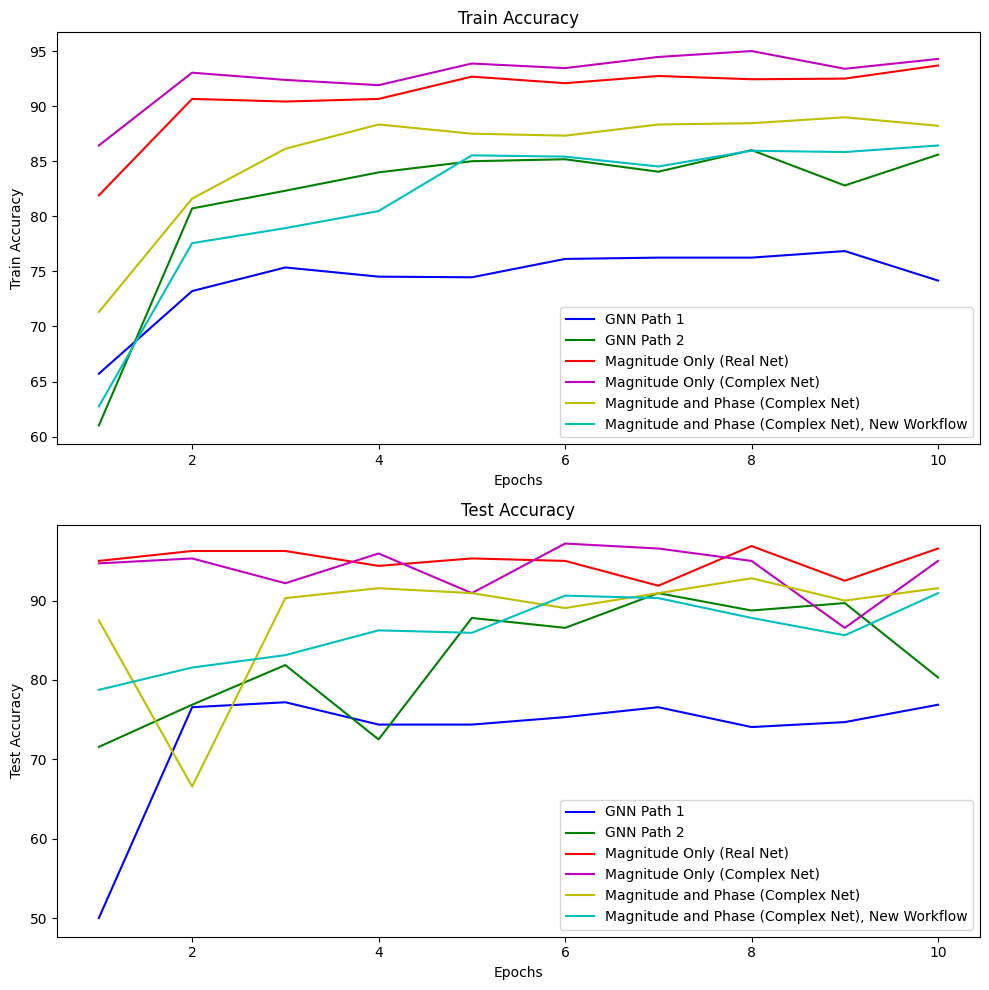

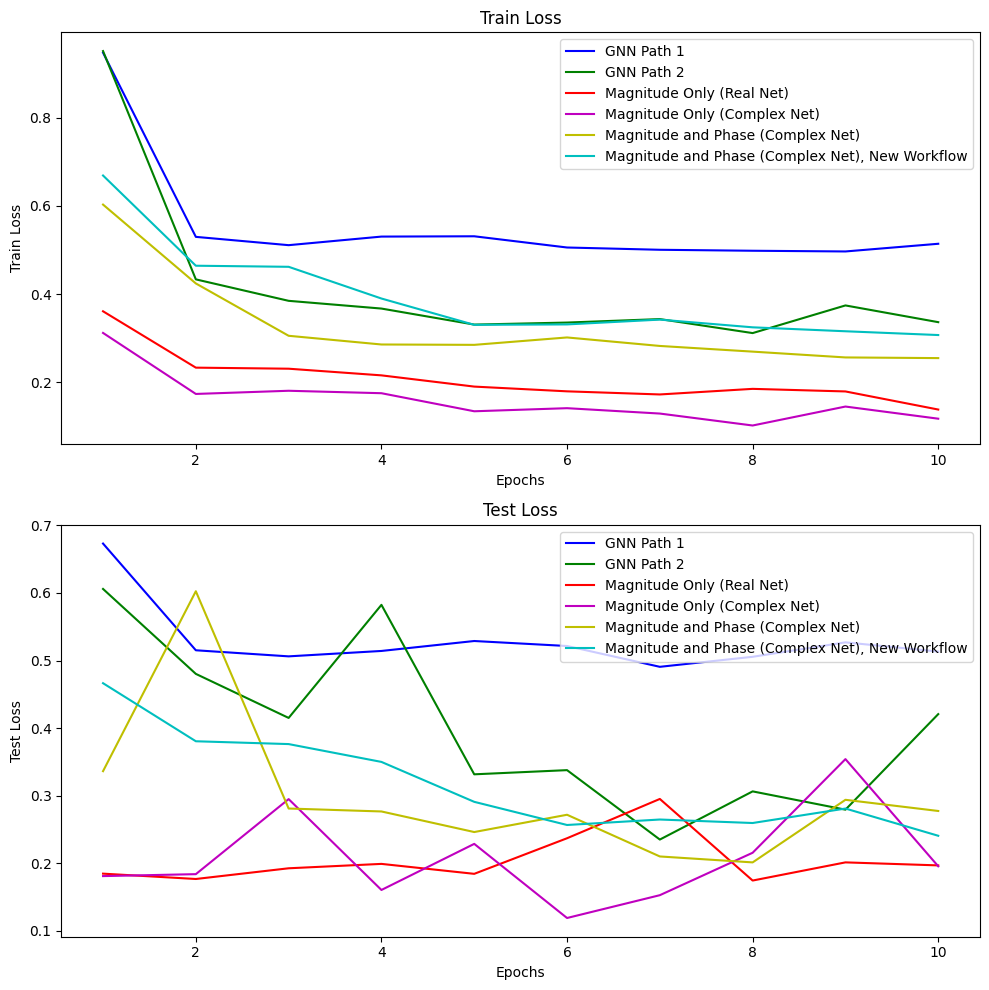

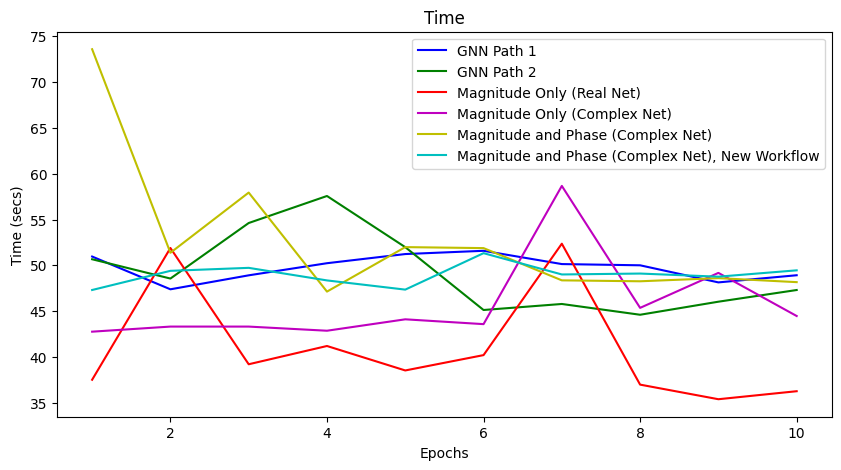

In [134]:
# Data for the four scenarios
data = {
    "GNN Path 1": metrics_dict_e1,
    "GNN Path 2": metrics_dict_e2,
}
data.update(data_old)

# Data for plotting
epochs = range(1, 11)
colors = ['b', 'g', 'r', 'm', 'y', 'c', 'k', '#FF5733', '#7E4DFF']
scenarios = list(data.keys())

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for i, scenario in enumerate(scenarios):
    axes[0].plot(epochs, data[scenario]["train_accuracies"], label=scenario, color=colors[i])

axes[0].set_title("Train Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Train Accuracy")
axes[0].legend()

for i, scenario in enumerate(scenarios):
    axes[1].plot(epochs, data[scenario]["test_accuracies"], label=scenario, color=colors[i])

axes[1].set_title("Test Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Test Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for i, scenario in enumerate(scenarios):
    axes[0].plot(epochs, data[scenario]["train_losses"], label=scenario, color=colors[i])

axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Train Loss")
axes[0].legend()

for i, scenario in enumerate(scenarios):
    axes[1].plot(epochs, data[scenario]["test_losses"], label=scenario, color=colors[i])

axes[1].set_title("Test Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Test Loss")
axes[1].legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
for i, scenario in enumerate(scenarios):
    axes.plot(epochs, data[scenario]["epoch_times"], label=scenario, color=colors[i])
axes.set_title("Time")
axes.set_xlabel("Epochs")
axes.set_ylabel("Time (secs)")
axes.legend()


# New tests

In [25]:
train_dataset = GenreDatasetMFCC("Data/train/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13, training = True)
test_dataset = GenreDatasetMFCC("Data/test/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13, training = False)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

In [26]:
class MusicGenreCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MusicGenreCNN, self).__init__()
        # Convolutional layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(2, 2), stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        # Convolutional layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(2, 2), stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        # Convolutional layer 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(2, 2), stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        # Fully connected layers
        self.fc1 = nn.Linear(32*2*16, 128)  # Calculate the input size based on the output of the last convolutional layer
        self.dropout1 = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.bn3(x)
        # Flatten the output from convolutional layers
        x = x.view(-1, 32*2*16)
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        # x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MusicGenreCNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e1 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e1,
          complexify = False)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e1.items():
    print(f'{key}: {value}')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch:   0 [     0/  8390 (  0%)]	Loss: 2.314024	Accuracy: 3.12%
Train Epoch:   0 [  3200/  8390 ( 38%)]	Loss: 2.125767	Accuracy: 21.47%
Train Epoch:   0 [  6400/  8390 ( 76%)]	Loss: 1.655676	Accuracy: 26.13%
Epoch 0 - Time: 245.61s - Train Loss: 1.956277 - Train Accuracy: 28.39%
Test Loss: 1.593823 - Test Accuracy: 39.88%

Train Epoch:   1 [     0/  8390 (  0%)]	Loss: 1.552146	Accuracy: 40.62%
Train Epoch:   1 [  3200/  8390 ( 38%)]	Loss: 1.798871	Accuracy: 38.92%
Train Epoch:   1 [  6400/  8390 ( 76%)]	Loss: 1.966438	Accuracy: 39.41%
Epoch 1 - Time: 347.25s - Train Loss: 1.686377 - Train Accuracy: 39.64%
Test Loss: 1.874927 - Test Accuracy: 33.62%

Train Epoch:   2 [     0/  8390 (  0%)]	Loss: 1.946245	Accuracy: 28.12%
Train Epoch:   2 [  3200/  8390 ( 38%)]	Loss: 1.531912	Accuracy: 42.70%
Train Epoch:   2 [  6400/  8390 ( 76%)]	Loss: 1.755229	Accuracy: 42.34%
Epoch 2 - Time: 408.28s - Train Loss: 1.613709 - Train Accuracy: 42.07%
Test Loss: 1.645144 - Test Accuracy: 39.69%

Tr

In [316]:
class MusicGenreCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MusicGenreCNN, self).__init__()
        # Convolutional layer 1
        self.conv1 = ComplexConv2d(in_channels=1, out_channels=32, kernel_size=(2, 2), stride=1, padding=1)
        self.pool1 = ComplexMaxPool2d(kernel_size=3, stride=2)
        self.bn1 = ComplexBatchNorm2d(32)
        # Convolutional layer 2
        self.conv2 = ComplexConv2d(in_channels=32, out_channels=32, kernel_size=(2, 2), stride=1, padding=1)
        self.pool2 = ComplexMaxPool2d(kernel_size=2, stride=2)
        self.bn2 = ComplexBatchNorm2d(32)
        # Fully connected layers
        self.fc1 = ComplexLinear(32*3*32, 128)  # Calculate the input size based on the output of the last convolutional layer
        self.dropout1 = ComplexDropout2d(0.5)
        self.fc2 = ComplexLinear(128, 64)
        self.dropout2 = ComplexDropout2d(0.5)
        self.fc3 = ComplexLinear(64, num_classes)

    def forward(self, x):
        # Convolutional layers
        x = complex_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bn1(x)
        x = complex_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        # Flatten the output from convolutional layers
        x = x.view(-1, 32*3*32)
        # Fully connected layers
        x = complex_relu(self.fc1(x))
        x = self.dropout1(x)
        x = complex_relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MusicGenreCNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e2 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e2)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e1.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  8391 (  0%)]	Loss: 3.944771	Accuracy: 6.25%
Train Epoch:   0 [  3200/  8391 ( 38%)]	Loss: 4.547935	Accuracy: 9.72%
Train Epoch:   0 [  6400/  8391 ( 76%)]	Loss: nan	Accuracy: 10.14%
Epoch 0 - Time: 32.63s - Train Loss: nan - Train Accuracy: 9.99%
Test Loss: nan - Test Accuracy: 10.57%

Train Epoch:   1 [     0/  8391 (  0%)]	Loss: nan	Accuracy: 3.12%
Train Epoch:   1 [  3200/  8391 ( 38%)]	Loss: nan	Accuracy: 10.64%
Train Epoch:   1 [  6400/  8391 ( 76%)]	Loss: nan	Accuracy: 10.25%
Epoch 1 - Time: 33.74s - Train Loss: nan - Train Accuracy: 9.90%
Test Loss: nan - Test Accuracy: 10.57%

Train Epoch:   2 [     0/  8391 (  0%)]	Loss: nan	Accuracy: 9.38%
Train Epoch:   2 [  3200/  8391 ( 38%)]	Loss: nan	Accuracy: 10.27%
Train Epoch:   2 [  6400/  8391 ( 76%)]	Loss: nan	Accuracy: 9.70%
Epoch 2 - Time: 33.57s - Train Loss: nan - Train Accuracy: 9.90%
Test Loss: nan - Test Accuracy: 10.57%

Train Epoch:   3 [     0/  8391 (  0%)]	Loss: nan	Accuracy: 6.25%
Train Epoch

KeyboardInterrupt: 

In [313]:
class MusicGenreCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MusicGenreCNN, self).__init__()
        # Convolutional layer 1
        self.conv1 = ComplexConv2d(in_channels=1, out_channels=32, kernel_size=(2, 2), stride=1, padding=1)
        self.pool1 = ComplexMaxPool2d(kernel_size=3, stride=2)
        self.bn1 = ComplexBatchNorm2d(32)
        # Convolutional layer 2
        self.conv2 = ComplexConv2d(in_channels=32, out_channels=32, kernel_size=(2, 2), stride=1, padding=1)
        self.pool2 = ComplexMaxPool2d(kernel_size=3, stride=2)
        self.bn2 = ComplexBatchNorm2d(32)
        # Convolutional layer 3
        self.conv3 = ComplexConv2d(in_channels=32, out_channels=32, kernel_size=(2, 2), stride=1, padding=1)
        self.pool3 = ComplexMaxPool2d(kernel_size=2, stride=2)
        self.bn3 = ComplexBatchNorm2d(32)
        # Fully connected layers
        self.fc1 = ComplexLinear(32*2*16, 128)  # Calculate the input size based on the output of the last convolutional layer
        self.dropout1 = ComplexDropout2d(0.5)
        self.fc2 = ComplexLinear(128, 64)
        self.dropout2 = ComplexDropout2d(0.5)
        self.fc3 = ComplexLinear(64, num_classes)

    def forward(self, x):
        # Convolutional layers
        x = complex_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bn1(x)
        x = complex_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        x = complex_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.bn3(x)
        # Flatten the output from convolutional layers
        x = x.view(-1, 32*2*16)
        # Fully connected layers
        x = complex_relu(self.fc1(x))
        x = self.dropout1(x)
        x = complex_relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MusicGenreCNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e2 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e2)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e1.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  8391 (  0%)]	Loss: 4.588666	Accuracy: 6.25%
Train Epoch:   0 [  3200/  8391 ( 38%)]	Loss: 2.308059	Accuracy: 11.70%
Train Epoch:   0 [  6400/  8391 ( 76%)]	Loss: 2.300663	Accuracy: 10.95%
Epoch 0 - Time: 41.36s - Train Loss: 2.475049 - Train Accuracy: 10.93%
Test Loss: 2.305991 - Test Accuracy: 8.44%

Train Epoch:   1 [     0/  8391 (  0%)]	Loss: 2.301869	Accuracy: 3.12%
Train Epoch:   1 [  3200/  8391 ( 38%)]	Loss: 2.336824	Accuracy: 9.72%
Train Epoch:   1 [  6400/  8391 ( 76%)]	Loss: 2.297295	Accuracy: 9.51%
Epoch 1 - Time: 41.57s - Train Loss: 2.308495 - Train Accuracy: 9.81%
Test Loss: 2.306710 - Test Accuracy: 10.19%

Train Epoch:   2 [     0/  8391 (  0%)]	Loss: 2.311068	Accuracy: 6.25%
Train Epoch:   2 [  3200/  8391 ( 38%)]	Loss: 2.304787	Accuracy: 9.65%
Train Epoch:   2 [  6400/  8391 ( 76%)]	Loss: 2.314088	Accuracy: 9.39%
Epoch 2 - Time: 41.58s - Train Loss: 2.306683 - Train Accuracy: 9.56%
Test Loss: 2.305398 - Test Accuracy: 9.82%

Train Epoch:   

KeyboardInterrupt: 

#### 2. Phase data

In [320]:
dataset = GenreDatasetPhaseMFCC("Data/genres_original/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.16, random_state=42)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

In [321]:
class MusicGenreCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MusicGenreCNN, self).__init__()
        # Convolutional layer 1
        self.conv1 = ComplexConv2d(in_channels=1, out_channels=32, kernel_size=(2, 2), stride=1, padding=1)
        self.pool1 = ComplexMaxPool2d(kernel_size=3, stride=2)
        self.bn1 = ComplexBatchNorm2d(32)
        # Convolutional layer 2
        self.conv2 = ComplexConv2d(in_channels=32, out_channels=32, kernel_size=(2, 2), stride=1, padding=1)
        self.pool2 = ComplexMaxPool2d(kernel_size=3, stride=2)
        self.bn2 = ComplexBatchNorm2d(32)
        # Convolutional layer 3
        self.conv3 = ComplexConv2d(in_channels=32, out_channels=32, kernel_size=(2, 2), stride=1, padding=1)
        self.pool3 = ComplexMaxPool2d(kernel_size=2, stride=2)
        self.bn3 = ComplexBatchNorm2d(32)
        # Fully connected layers
        self.fc1 = ComplexLinear(32*2*16, 128)  # Calculate the input size based on the output of the last convolutional layer
        self.dropout1 = ComplexDropout2d(0.5)
        self.fc2 = ComplexLinear(128, 64)
        self.dropout2 = ComplexDropout2d(0.5)
        self.fc3 = ComplexLinear(64, num_classes)

    def forward(self, x):
        # Convolutional layers
        x = complex_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bn1(x)
        x = complex_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        x = complex_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.bn3(x)
        # Flatten the output from convolutional layers
        x = x.view(-1, 32*2*16)
        # Fully connected layers
        x = complex_relu(self.fc1(x))
        x = self.dropout1(x)
        x = complex_relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MusicGenreCNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e2 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e2)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e2.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  8391 (  0%)]	Loss: 4.102013	Accuracy: 6.25%
Train Epoch:   0 [  3200/  8391 ( 38%)]	Loss: 2.352618	Accuracy: 11.17%
Train Epoch:   0 [  6400/  8391 ( 76%)]	Loss: 2.299697	Accuracy: 10.81%
Epoch 0 - Time: 41.16s - Train Loss: 2.421256 - Train Accuracy: 10.56%
Test Loss: 2.305844 - Test Accuracy: 9.51%

Train Epoch:   1 [     0/  8391 (  0%)]	Loss: 2.314598	Accuracy: 12.50%
Train Epoch:   1 [  3200/  8391 ( 38%)]	Loss: 2.299663	Accuracy: 10.67%
Train Epoch:   1 [  6400/  8391 ( 76%)]	Loss: 2.307384	Accuracy: 10.21%
Epoch 1 - Time: 41.78s - Train Loss: 2.306584 - Train Accuracy: 9.70%
Test Loss: 2.302605 - Test Accuracy: 10.82%

Train Epoch:   2 [     0/  8391 (  0%)]	Loss: 2.306377	Accuracy: 12.50%
Train Epoch:   2 [  3200/  8391 ( 38%)]	Loss: 2.305488	Accuracy: 9.53%
Train Epoch:   2 [  6400/  8391 ( 76%)]	Loss: 2.296465	Accuracy: 9.64%
Epoch 2 - Time: 42.32s - Train Loss: 2.305501 - Train Accuracy: 9.43%
Test Loss: 2.303694 - Test Accuracy: 10.38%

Train Epoc

In [322]:
print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e2.items():
    print(f'{key}: {value}')

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
FINAL RESULTS:
----------------------------------------------------------------------------------------------------
epoch_times: [41.16187524795532, 41.7832088470459, 42.31985092163086, 42.900376081466675, 42.894107818603516, 43.12066102027893, 43.55217790603638, 43.7485990524292, 43.4820830821991, 43.424493074417114, 43.10460901260376, 42.867106676101685, 42.81493282318115, 42.962246894836426, 43.437156677246094, 43.67679286003113, 43.23204469680786, 43.20026421546936, 43.1420738697052, 43.18421506881714, 43.88410019874573, 42.85453677177429, 43.61320924758911, 43.36027717590332, 43.5458459854126, 42.96121597290039, 43.42939496040344, 43.28667902946472, 43.05354690551758, 43.22593092918396, 42.77023720741272, 42.87620186805725, 43.50260806083679, 43.79348421096802, 43.71834707260132, 43

### Specs:

In [ ]:
class GenreDataset(Dataset):

    def __init__(self, train_path, n_fft=2048, hop_length=512, num_segments=10):
        cur_path = pathlib.Path(train_path)
        self.files = []
        for i in list(cur_path.rglob("*.wav")):
            for j in range(num_segments):
                self.files.append([j, i])
        self.samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.num_segments = num_segments

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        cur_file = self.files[idx]
        d = cur_file[0]
        file_path = cur_file[1]
        target = genre_mappings[str(file_path).split("/")[2]]
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        start = self.samples_per_segment * d
        finish = start + self.samples_per_segment
        cur_signal = signal[start:finish]
        cur_spec = librosa.stft(cur_signal, n_fft = self.n_fft, hop_length = self.hop_length)
        return torch.tensor(np.array([np.abs(cur_spec)]), dtype = torch.complex64), target

class GenreDatasetPhase(GenreDataset):

    def __init__(self, train_path, n_fft=2048, hop_length=512, num_segments=10):
        super().__init__(train_path, n_fft, hop_length, num_segments)

    def __getitem__(self, idx):
        cur_file = self.files[idx]
        d = cur_file[0]
        file_path = cur_file[1]
        target = genre_mappings[str(file_path).split("/")[2]]
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        start = self.samples_per_segment * d
        finish = start + self.samples_per_segment
        cur_signal = signal[start:finish]
        cur_spec = librosa.stft(cur_signal, n_fft = self.n_fft, hop_length = self.hop_length)
        return torch.tensor(np.array([cur_spec]), dtype = torch.complex64), target

train_set = GenreDataset("Data/genres_original/")
train_loader = torch.utils.data.DataLoader(dataset=train_set, shuffle=True, batch_size = BATCH_SIZE, drop_last=True)

In [83]:
class MusicGenreCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MusicGenreCNN, self).__init__()
        # Convolutional layers
        self.conv1 = ComplexConv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = ComplexBatchNorm2d(16)
        self.conv2 = ComplexConv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = ComplexMaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = ComplexLinear(65*512*32, 256)  # Calculate the input size based on the output of the last convolutional layer
        self.fc2 = ComplexLinear(256, 10)

    def forward(self, x):
        # Convolutional layers
        x = complex_relu(self.conv1(x))
        print(x.shape)
        x = self.bn1(x)
        print(x.shape)
        x = complex_relu(self.conv2(x))
        print(x.shape)
        x = self.pool(x)
        print(x.shape)
        # Flatten the output from convolutional layers
        x = x.view(-1, 65*512*32)
        print(x.shape)
        # Fully connected layers
        x = complex_relu(self.fc1(x))
        x = self.fc2(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MusicGenreCNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [84]:
epoch_loss = {}
for epoch in range(10):
    cur_loss = train(model, device, train_loader, optimizer, epoch)
    epoch_loss[epoch] = cur_loss

torch.Size([32, 1, 1025, 130])
torch.Size([32, 16, 1025, 130])
torch.Size([32, 16, 1025, 130])
torch.Size([32, 32, 1025, 130])
torch.Size([32, 32, 512, 65])
torch.Size([32, 1064960])
torch.Size([32, 10])
Train Epoch: 0 [0/9990 (0.0%)]	Loss: 2.509779691696167
torch.Size([32, 1, 1025, 130])
torch.Size([32, 16, 1025, 130])
torch.Size([32, 16, 1025, 130])
torch.Size([32, 32, 1025, 130])
torch.Size([32, 32, 512, 65])
torch.Size([32, 1064960])
torch.Size([32, 10])
Train Epoch: 0 [32/9990 (0.32051%)]	Loss: 87.92473602294922
torch.Size([32, 1, 1025, 130])
torch.Size([32, 16, 1025, 130])
torch.Size([32, 16, 1025, 130])
torch.Size([32, 32, 1025, 130])
torch.Size([32, 32, 512, 65])
torch.Size([32, 1064960])
torch.Size([32, 10])
Train Epoch: 0 [64/9990 (0.64103%)]	Loss: 962.5475463867188
torch.Size([32, 1, 1025, 130])
torch.Size([32, 16, 1025, 130])
torch.Size([32, 16, 1025, 130])
torch.Size([32, 32, 1025, 130])
torch.Size([32, 32, 512, 65])
torch.Size([32, 1064960])
torch.Size([32, 10])
Train Epo

RuntimeError: stack expects each tensor to be equal size, but got [1, 1025, 130] at entry 0 and [1, 1025, 129] at entry 19

In [63]:
class RealNet(nn.Module):
    def __init__(self):
        super(RealNet, self).__init__()
        self.conv1 = ComplexConv2d(1, 32, (3, 3))
        self.bn1 = ComplexBatchNorm2d(32)
        self.conv2 = ComplexConv2d(32, 64, (3, 3))
        self.bn2 = ComplexBatchNorm2d(64)
        self.conv3 = ComplexConv2d(64, 32, (2, 2))
        self.bn3 = ComplexBatchNorm2d(32)
        self.fc1 = ComplexLinear(32*127*15, 64)
        self.dropout = ComplexDropout2d(0.3)
        self.fc2 = ComplexLinear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, (3, 3), stride=(2, 2), padding=(1, 1))
        x = self.bn1(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, (3, 3), stride=(2, 2), padding=(1, 1))
        x = self.bn2(x)
        x = self.conv3(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, (3, 3), stride=(2, 2), padding=(1, 1))
        x = self.bn3(x)
        x = x.view(32, 32*127*15)
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RealNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [64]:
epoch_loss = {}
for epoch in range(10):
    cur_loss = train(model, device, train_loader, optimizer, epoch)
    epoch_loss[epoch] = cur_loss

torch.Size([32, 1, 1025, 130])


[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 